In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
FILE_PATH = "media/sample_leads_10.csv"
EMAIL_TEMPLATE = "media/email_template.md"

In [3]:
import csv
from dataclasses import dataclass


@dataclass
class Lead:
    name: str
    email: str
    company: str
    job_title: str
    industry: str

    def str(self):
        return f"""name={self.name}, email={self.email}, 
                company={self.company}, job_title={self.job_title}, 
                industry={self.industry}"""


def lead_iterator():
    with open(FILE_PATH, newline="") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            yield Lead(
                name=row["Name"],
                email=row["Email"],
                company=row["Company"],
                job_title=row["Job Title"],
                industry=row["Industry"],
            ).str()

leads = lead_iterator()

In [4]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage


eca_sys_msg = SystemMessage(content="Write an email based on the given template by filling in the lead details in the template.")
qca_sys_msg = SystemMessage(content="You are a helpful assistant tasked with comparing two emails and selecting the best one.\
return LLM_1 for first email or LLM_2 for second.")


def get_email_template() -> str:
    """Get email template"""
    with open(EMAIL_TEMPLATE, "r") as f:
        return f.read().replace('\\n','\n')

def get_lead() -> int:
    """Get next lead from lead iterator"""
    return next(leads)

def email_agent_1(lead_details: str) -> str:
    """Email Construction Agent 1 used to write email based on lead data
    
    Args:
        lead_details: str
    """
    llm_EA1 = ChatOpenAI(model="gpt-4")
    return llm_EA1.invoke([eca_sys_msg] + [SystemMessage(content=lead_details)])


def email_agent_2(lead_details: str) -> str:
    """Email Construction Agent 2 used to write email based on lead data
    
    Args:
        lead_details: str
    """
    llm_EA2 = ChatOpenAI(model="gpt-3.5-turbo")    
    return llm_EA2.invoke([eca_sys_msg] + [SystemMessage(content=lead_details)])

def quality_check_agent(email_1: str, email_2: str) -> str:
    """Quality check email used to compare and select the best email out of two.
    
    Args:
        email_1: str
        email_2: str
    """
    llm_QCA = ChatOpenAI(model="gpt-4o")
    return llm_QCA.invoke([qca_sys_msg] + [SystemMessage(content=email_1 + email_2)])


def save_to_file(name: str, email: str, company: str, job_title: str, email_llm_1: str, email_llm_2: str, selected_email: str) -> None:
    """Store both generated emails along with the comparison result in a file."""
    import json
    with open(f'generated/{name}.json', 'w') as f:
        json.dump({
        "name": name,
        "email": email,
        "company": company,
        "job_title": job_title,
        "email_llm_1": email_llm_1,
        "email_llm_2": email_llm_2,
        "selected_email": selected_email
    }, f)


tools = [get_lead, get_email_template, email_agent_1, email_agent_2, quality_check_agent, save_to_file]

llm_orchestrator = ChatOpenAI(model="gpt-3.5-turbo")

llm_with_tools = llm_orchestrator.bind_tools(tools)

In [5]:

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with writing emails for business leads. \
Use Email Construction Agents and write two different emails for the same lead. \
Once you have the two emails use Quality Check Agent to select best one. Which will tell LLM_1 or LLM_2\
Save all the output in a file. ")


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


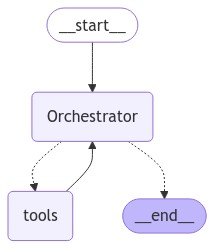

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("Orchestrator", assistant)

builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "Orchestrator")
builder.add_conditional_edges(
    "Orchestrator",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "Orchestrator")

react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [11]:
messages = [HumanMessage(content="Get one lead and email template and use email_agent_1 and email_agent_2 to write 2 emails and quality_check_agent to pick the best out of two. Save the output to a file.")]
messages = react_graph.invoke({"messages": messages})

In [12]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Get one lead and email template and use email_agent_1 and email_agent_2 to write 2 emails and quality_check_agent to pick the best out of two. Save the output to a file.
================================== Ai Message ==================================
Tool Calls:
  get_lead (call_EwARu3plD9CP2UYXgciz8Zga)
 Call ID: call_EwARu3plD9CP2UYXgciz8Zga
  Args:
================================= Tool Message =================================
Name: get_lead

name=Bob Brown, email=bob.brown@example.com, 
                company=Global Enterprises, job_title=CEO, 
                industry=Retail
================================== Ai Message ==================================
Tool Calls:
  get_email_template (call_QKCJ6t5EvTcLfUvBm4WSHxz5)
 Call ID: call_QKCJ6t5EvTcLfUvBm4WSHxz5
  Args:
================================= Tool Message =================================
Name: get_email_template

Subject: Introducing [Produc